In [ ]:
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

## Import

In [ ]:
import os, gc, warnings, random, math
import datetime
from datetime import timedelta
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
!pip install tqdm
from tqdm import tqdm
import time
import copy
import pickle
import json

from time import sleep
from tqdm.contrib import tzip

warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adagrad
#from tensorflow.keras.optimizers import LambdaCallback
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

import torch
from torch.optim import Rprop

from random import seed

from tensorflow.keras import backend as K
from tensorflow.keras import initializers

from math import floor
from itertools import chain

import pandas as pd
import numpy as np
import operator
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler #менее подвержан выбросам
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
!pip install imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,matthews_corrcoef,recall_score,precision_score,classification_report,f1_score,cohen_kappa_score, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Настройки визуализации
%matplotlib inline
plt.style.use('ggplot')
sns.set(style='whitegrid')
sns.set_context('talk')
%config InlineBackend.figure_format = 'svg' #Отображение графиков в формате svg

## Определение функций

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues, norm=False, name = "default"):
    """
    Эта функция строит матрицу ошибок
    """
    fig, ax = plt.subplots(figsize=(12,8))
    
    if norm == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round_(cm, decimals=3)
    
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.grid(False)
    thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/confusion_matrix_{name}_{thetime}.svg')
    plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/confusion_matrix_{name}_{thetime}.png', dpi=300)
    plt.show()

def conf_matrix_bin (y_true, y_predict):
  TP = sum(np.array([(1 if (y_true[i]==1 and y_predict[i]==1) else 0) for i in range(len(y_true))]))
  FP = sum(np.array([(1 if (y_true[i]==0 and y_predict[i]==1) else 0) for i in range(len(y_true))]))
  FN = sum(np.array([(1 if (y_true[i]==1 and y_predict[i]==0) else 0) for i in range(len(y_true))]))
  TN = sum(np.array([(1 if (y_true[i]==0 and y_predict[i]==0) else 0) for i in range(len(y_true))]))
  return TP, FP, FN, TN


def accuracy_score(y_true, y_predict):
  TP, FP, FN, TN = conf_matrix_bin(y_true, y_predict)
  result = (TP+TN)/(TP+TN+FP+FN)
  return result

In [ ]:
###################################################################################
def max_min_scaler_norm_for_columns (df):
  """Нормализует столбцы dataframe"""
  columns = []
  columns = df.columns
  target_columns = []
  for i in columns:
    if (df[i].max() > 1)or(df[i].min() < 0):
      target_columns.append(i)
  for i in target_columns:
    df[i] = (df[i] - df[i].min())/(df[i].max()-df[i].min())

def max_min_scaler_norm_for_the_columns (df, columns):
  """Нормализует столбцы dataframe"""
  for i in columns:
    df[i] = (df[i] - df[i].min())/(df[i].max()-df[i].min())

def max_min_scaler_denorm_for_the_column (array_to_denorm, source_df, column):
  """Денормализует заданый столбец"""
  denormed_array = (array_to_denorm + source_df[column].min())*(source_df[column].max()-source_df[column].min())  
  return denormed_array
###################################################################################

In [ ]:
def dataframe_to_data_and_target_lists (df, long_of_list):
  """Построение data и target"""
  array_df = df.to_numpy()
  data = np.zeros((len(array_df)-long_of_list,long_of_list,len(df.columns)), dtype = float)
  target = np.zeros((len(array_df)-long_of_list, 1), dtype = float)
  for i in range(0, (len(array_df)-long_of_list)):
    for j in range(0, long_of_list):
      data[i][j] = array_df[i+j]
  for k in range(0, (len(array_df)-long_of_list)):
    target[k] = array_df[k+long_of_list][0]                       #Время должно быть в первом столбце
  return np.array(data, dtype = float), np.array(target, dtype = float)

## Основные параметры модуля

In [ ]:
DATA_PATH = '../data/'
PNG_PATH = '../png/'
PREPROCESSED_DATA_PATH = '../preprocessed data/'
LSTM_MODELS_PATH = '../lstm_models/'
LSTM_RESULTS_PATH = '../lstm_results/'
LSTM_HISTORY_PATH = '../lstm_histories/'

# Данные имитационного моделирования

## Получение данных

In [ ]:
df_svista = pd.read_csv(f'{PREPROCESSED_DATA_PATH}prep_data_syn_IM.csv')

In [ ]:
df_svista

## Модели для отдельных карт

#####Dictionary creating

In [ ]:
df_sv_card = {}
#Построение словаря содержащего транзакции по отдельным картам
for i in df_svista['CARDID_NUM'].unique():
  df_sv_card[i] = df_svista[df_svista['CARDID_NUM']==i]
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

In [ ]:
print("Количество признаков по каждой карте:")
for i in df_sv_card.keys():
  print(i,":", len(df_sv_card[i].columns))

In [ ]:
df_sv_card[1].columns

Index(['MERCH_ID', 'AMOUNT', 'DATE_TIME_SEC', 'TIME_DIFF', 'TRANS_TYPE_freq'], dtype='object')

##### Нормализация

In [ ]:
### Передвигаем столбцы в начало
for i in df_sv_card.keys():
  DATE_TIME_SEC_array = df_sv_card[i]['DATE_TIME_SEC']
  df_sv_card[i].drop(['DATE_TIME_SEC'], axis=1, inplace=True)
  df_sv_card[i].insert(0, 'DATE_TIME_SEC', DATE_TIME_SEC_array)

In [ ]:
df_sv_card[1]

In [ ]:
df_sv_card_normalized = {}
sv_scalers = {}
for i in df_sv_card.keys():
  df_sv_card_normalized[i] = df_sv_card[i].copy(deep=True)
  max_min_scaler_norm_for_columns(df_sv_card_normalized[i])

In [ ]:
df_sv_card_normalized[1]

#####Построение data & target

In [ ]:
df_sv_card_normalized_copy = {}
for i in df_sv_card_normalized.keys():
  df_sv_card_normalized_copy[i] = df_sv_card_normalized[i].copy(deep=True)

In [ ]:
df_sv_card_normalized[1]

In [ ]:
data_sv = {}
target_sv = {}
### Количество транзакций в одном ряду (предсказываем время long_of_list+1 исходя из long_of_list прошлых)
### Для тестов с различными параметрами модели
long_of_list = 40
for i in df_sv_card.keys():
  data_sv[i], target_sv[i] = dataframe_to_data_and_target_lists(df_sv_card_normalized[i], long_of_list)

###Обучение моделей

In [ ]:
data_sv_ns = {}
target_sv_ns = {}

x_train_d = {}
x_test_d = {}
y_train_d = {}
y_test_d = {}

In [ ]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.4.1
Default GPU Device: /device:GPU:0


In [ ]:
models = []
for i in tqdm(df_sv_card.keys()):
  x_train_d[i],x_test_d[i],y_train_d[i],y_test_d[i] = train_test_split(data_sv[i],target_sv[i],test_size=0.2, shuffle = False, random_state=4)
  seed(42)
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(5,batch_input_shape=(None, data_sv[i].shape[1],data_sv[i].shape[2]), return_sequences=True)))
  model.add(Dropout(0.1))
  model.add(Bidirectional(CuDNNLSTM(5)))
  model.add(Dropout(0.1))
  #model.add(CuDNNLSTM(8))
  #model.add(Dropout(0.2))
  #model.add(CuDNNLSTM(5))
  #model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  models.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 21.18it/s]


In [ ]:
for model in models:
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['mae','accuracy'])

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=200)

In [ ]:
histories = [
    model.fit(
        x_train_d[i],y_train_d[i],epochs=2800,validation_data=(x_test_d[i],y_test_d[i]), callbacks=[callback], verbose=0
    ) for model, i in tzip(models, df_sv_card.keys())
]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
model_results = []
for model, i in tzip(models, df_sv_card.keys()):
  result = model.predict(x_test_d[i])
  model_results.append(result)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
for history in histories:
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  print(hist.tail())

          loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
1132  0.000298  0.012554       0.0  0.006046  0.069421      0.021739   1132
1133  0.000450  0.014930       0.0  0.006025  0.069408      0.021739   1133
1134  0.000325  0.013179       0.0  0.006009  0.069303      0.021739   1134
1135  0.000329  0.013030       0.0  0.005976  0.069053      0.021739   1135
1136  0.000333  0.013604       0.0  0.006417  0.072310      0.021739   1136
          loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
1641  0.000373  0.014836       0.0  0.004668  0.056375      0.021739   1641
1642  0.000349  0.013353       0.0  0.005315  0.062768      0.021739   1642
1643  0.000318  0.013109       0.0  0.004267  0.052583      0.021739   1643
1644  0.000426  0.015860       0.0  0.004651  0.056801      0.021739   1644
1645  0.000331  0.013362       0.0  0.005063  0.060703      0.021739   1645
          loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
1022  0.0003

### Сохранение результатов обучения

In [ ]:
for model, i in tzip(models, df_sv_card.keys()):
  model.save(f'{LSTM_MODELS_PATH}my_model_for_{i}_card_syn_IM.h5')

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
for (history, i) in tzip(histories, df_sv_card.keys()):
  history_df = pd.DataFrame(history.history)
  history_df['epoch'] = history.epoch
  #json.dump(history_dict, open(f'{LSTM_HISTORY_PATH}', 'w'))
  with open(f'{LSTM_HISTORY_PATH}history_for_{i}_card_syn_IM.csv', mode='w') as f:
    history_df.to_csv(f, index=False)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# Save prediction
with open(f"{LSTM_RESULTS_PATH}model_results_syn_IM.txt", "wb") as fp:
  pickle.dump(model_results, fp)

### Загрузка

In [ ]:
with open(f"{LSTM_RESULTS_PATH}model_results_syn_IM.txt", "rb") as fp:
  model_results_save = pickle.load(fp)

In [ ]:
model_results_save[0][0]

array([0.8119225], dtype=float32)

In [ ]:
histories_dict = {}
for i in tqdm(df_sv_card.keys()):
  histories_dict[i] = pd.read_csv(f'{LSTM_HISTORY_PATH}history_for_{i}_card_syn_IM.csv')

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 130.44it/s]


In [ ]:
histories_dict[1]

In [ ]:
models_dict = {}
for i in tqdm(df_sv_card.keys()):
  models_dict[i] = load_model(f'{LSTM_MODELS_PATH}my_model_for_{i}_card_syn_IM.h5')

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.07s/it]


In [ ]:
model_results_save

In [ ]:

# Проверка модели
model_results_load = []
j=0
for i in tqdm(df_sv_card.keys()):
  result = models_dict[i].predict(x_test_d[i])
  model_results_load.append(result);
for index, i in enumerate(df_sv_card.keys()): 
  if all(model_results_load[index] == model_results_save[index]):
    pass
  else:
    j=j+1
    print('\n',f'False {i}')
    break
if j==0:
  print('\n','True')



### Визуализация

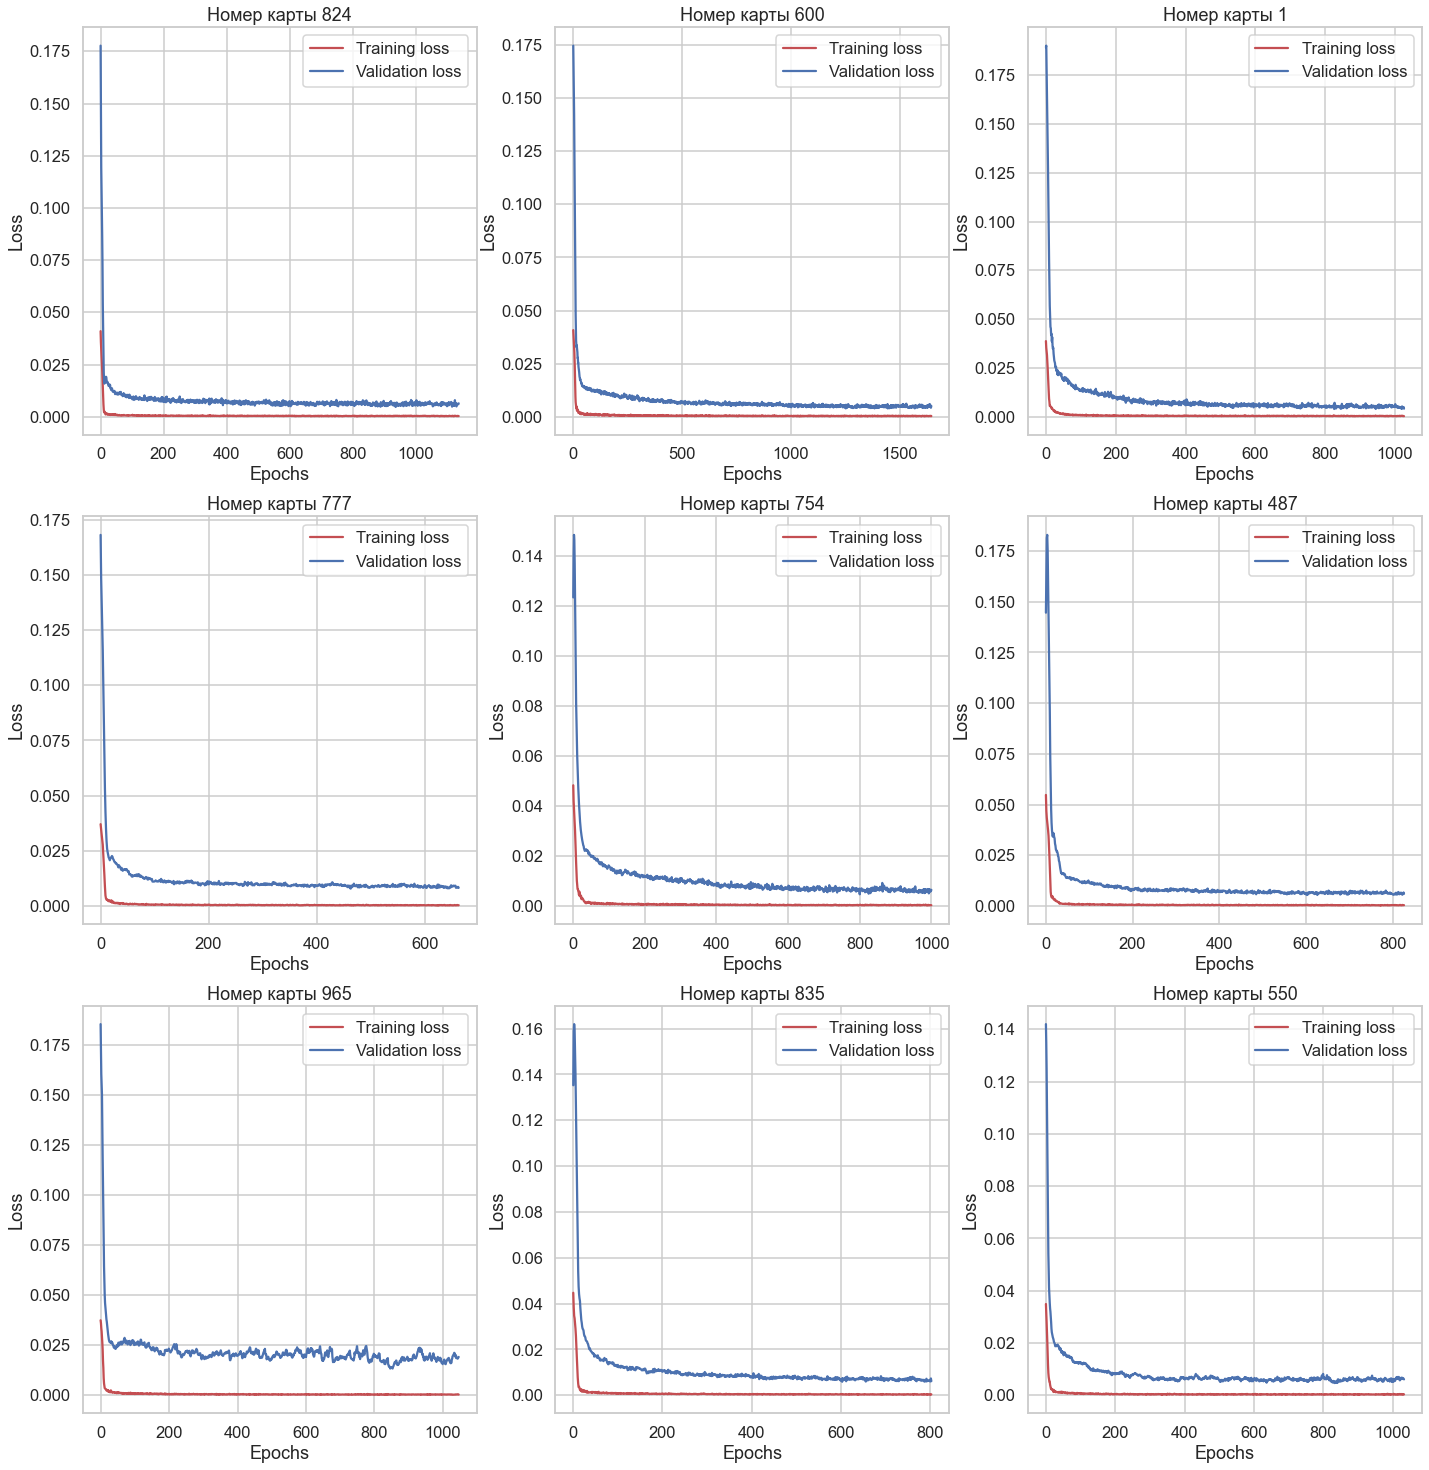

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for card_number in df_sv_card.keys():
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['loss'], 'r', label='Training loss')
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['val_loss'], 'b', label='Validation loss')
  plt.title(f'Номер карты {card_number}') 
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/loss_cards_syn_IM.png'):
  plt.savefig(f'{PNG_PATH}/loss_cards_syn_IM', dpi=100)
plt.show()

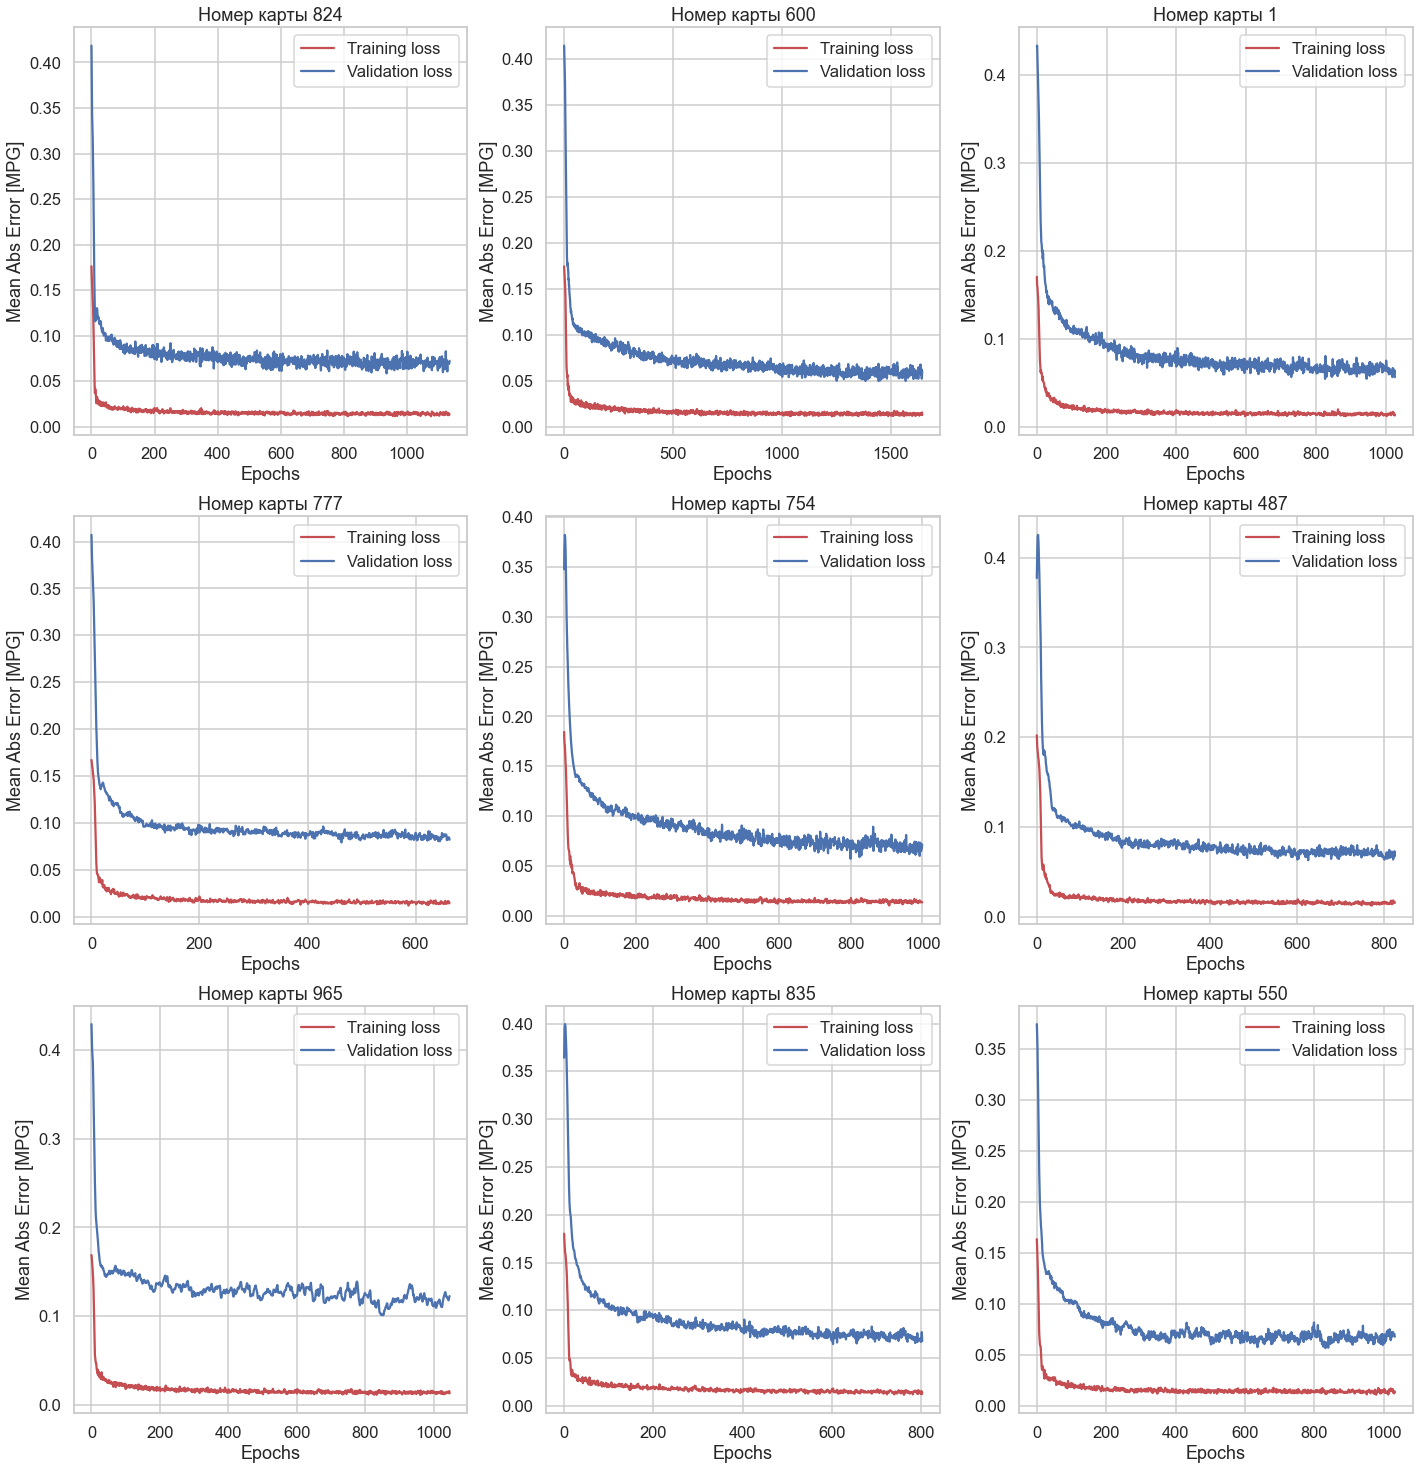

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for card_number in df_sv_card.keys():
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['mae'], 'r', label='Training loss')
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['val_mae'], 'b', label='Validation loss')
  plt.title(f'Номер карты {card_number}') 
  plt.xlabel('Epochs')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/mae_cards_syn_IM.png'):
  plt.savefig(f'{PNG_PATH}/mae_cards_syn_IM', dpi=100)
plt.show()

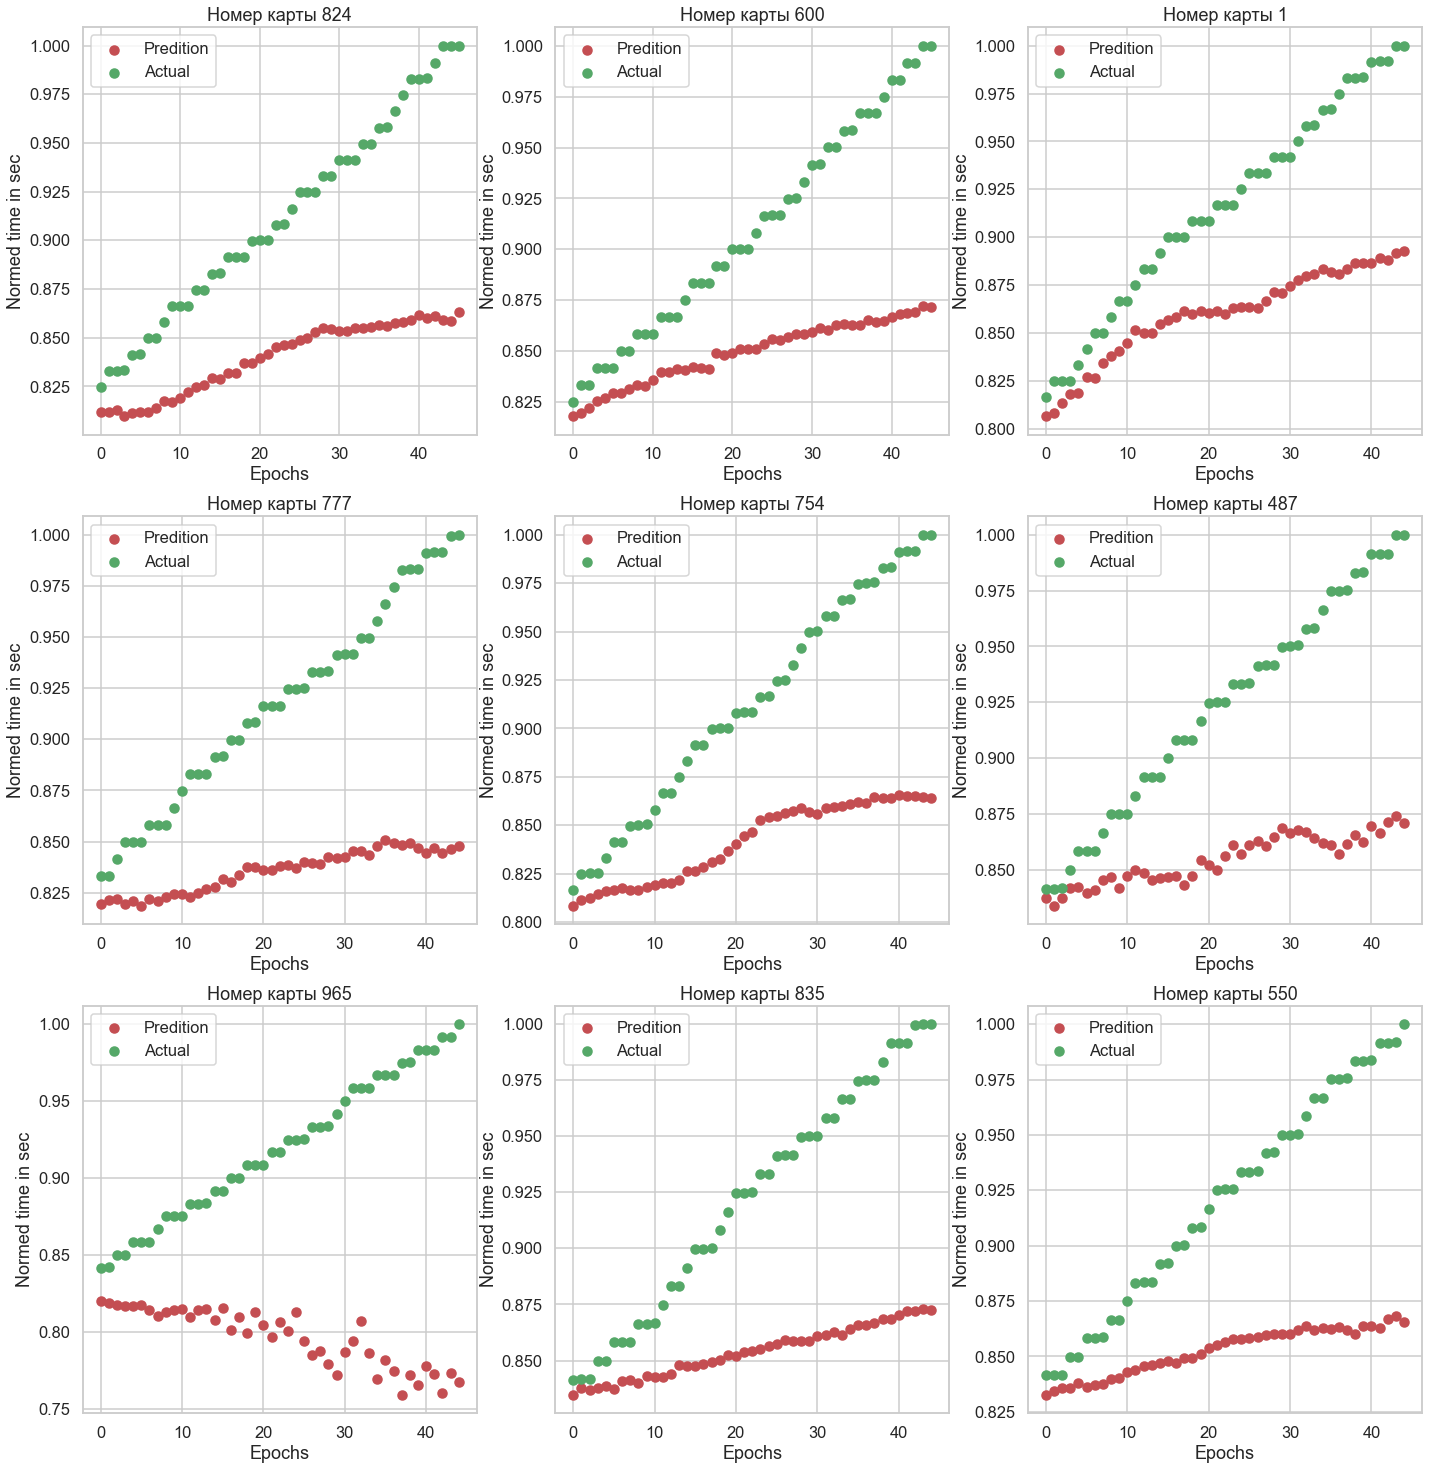

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for (result, i) in zip(model_results_save, df_sv_card.keys()):
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.scatter(range(y_test_d[i].shape[0]),np.array(result,dtype=float),c='r', label = 'Predition')
  plt.scatter(range(y_test_d[i].shape[0]),np.array(y_test_d[i],dtype=float),c='g', label = 'Actual')
  plt.title(f'Номер карты {i}') 
  plt.xlabel('Epochs')
  plt.ylabel('Normed time in sec')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/prediction_actual_cards_syn_IM.png'):
  plt.savefig(f'{PNG_PATH}/prediction_actual_cards_syn_IM', dpi=100)
plt.show()

### Получение accuracy

#### Денормализация

In [ ]:
data_sv_ns_t2 = copy.deepcopy(data_sv)

target_sv_ns_t2 = copy.deepcopy(target_sv)

x_train_d_t2 = copy.deepcopy(x_train_d)
x_test_d_t2 = copy.deepcopy(x_test_d)
y_train_d_t2 = copy.deepcopy(y_train_d)
y_test_d_t2 = copy.deepcopy(y_test_d)
model_results_t2 = copy.deepcopy(model_results_save)

In [ ]:
df_sv_card_normalized.keys()

dict_keys([824, 600, 1, 777, 754, 487, 965, 835, 550])

In [ ]:
### Денормализация
for index, i in enumerate(df_sv_card_normalized.keys()):
  
  for j in range(data_sv_ns_t2[i].shape[0]):
    data_sv_ns_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(data_sv_ns_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  target_sv_ns_t2[i][:,0] = max_min_scaler_denorm_for_the_column(target_sv_ns_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  for j in range(x_train_d_t2[i].shape[0]):
    x_train_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_train_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  for j in range(x_test_d_t2[i].shape[0]):
    x_test_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_test_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  y_train_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_train_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  y_test_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_test_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  model_results_t2[index][:,0] = max_min_scaler_denorm_for_the_column(model_results_t2[index][:,0], df_sv_card[i], 'DATE_TIME_SEC')


In [ ]:
print(x_train_d_t2[1].shape)
print(x_test_d_t2[1].shape)
print(y_train_d_t2[1].shape)
print(y_test_d_t2[1].shape)
print(data_sv[1].shape)
print(target_sv[1].shape)
print(model_results_t2[1].shape)

(179, 40, 5)
(45, 40, 5)
(179, 1)
(45, 1)
(224, 40, 5)
(224, 1)
(46, 1)


In [ ]:
for index, i in enumerate(df_sv_card_normalized.keys()):
  print(i, y_test_d_t2[i].shape, model_results_t2[index].shape, sep=' ')

824 (46, 1) (46, 1)
600 (46, 1) (46, 1)
1 (45, 1) (45, 1)
777 (45, 1) (45, 1)
754 (45, 1) (45, 1)
487 (45, 1) (45, 1)
965 (45, 1) (45, 1)
835 (45, 1) (45, 1)
550 (45, 1) (45, 1)


#### Получение бинарного признака и расчет accuracy для отдельных карт

In [ ]:
transaction_before_x_test = {}
actual_y_test = {}
prediction = {}
actual_class = {}
result_class = {}

In [ ]:
#Получаем время транзакций (последней в ряду, действительное время предсказываемой транзакции и предсказанное время)
for index, i in enumerate(df_sv_card_normalized.keys()):
  transaction_before_x_test[i] = x_test_d_t2[i][:,(x_test_d_t2[i].shape[1]-1),0] # последняя транзакция в ряду
  actual_y_test[i] = y_test_d_t2[i][:,0] #реальное время след транзакции по картам
  prediction[index] = model_results_t2[index][:,0] #предсказания по картам
  actual_class[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)
  result_class[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)

In [ ]:
actual_y_test.keys()

dict_keys([824, 600, 1, 777, 754, 487, 965, 835, 550])

In [ ]:
print(actual_y_test[1].shape,transaction_before_x_test[1].shape,prediction[2].shape, sep=' ')

(45,) (45,) (45,)


In [ ]:
#Строим массивы с бинарной классификацией транзакций которые произошли в следующие window_min минут после последней транзакции в ряду
window_min = 30
for index, j in enumerate(df_sv_card_normalized.keys()):
  for i in range(0, prediction[index].shape[0]):
    if (actual_y_test[j][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      actual_class[j][i] = 1
    else:
      actual_class[j][i] = 0
    if (prediction[index][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      result_class[j][i] = 1
    else:
      result_class[j][i] = 0
  actual_class[j] = actual_class[j].astype('int32')
  result_class[j] = result_class[j].astype('int32')

#### Получение среднего accuracy для кластеров

In [ ]:
accuracy_score(actual_class[1], result_class[1])

In [ ]:
for i in df_sv_card_normalized.keys():
  accuracy_cards[i] = accuracy_score(actual_class[i][:4], result_class[i][:4])

In [ ]:
mean_acc = 0
for i in df_sv_card_normalized.keys():
  mean_acc = mean_acc + accuracy_cards[i]
mean_acc = mean_acc/len(accuracy_cards)
print(mean_acc)

In [ ]:
accuracy_cards

# Данные DataSynthesizer

## Получение данных

In [ ]:
df_svista = pd.read_csv(f'{PREPROCESSED_DATA_PATH}prep_data_syn_DS.csv')

In [ ]:
df_svista

## Модели для отдельных карт

#####Dictionary creating

In [ ]:
df_sv_card = {}
#Построение словаря содержащего транзакции по отдельным картам
for i in df_svista['CARDID_NUM'].unique():
  df_sv_card[i] = df_svista[df_svista['CARDID_NUM']==i]
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

In [ ]:
print("Количество признаков по каждой карте:")
for i in df_sv_card.keys():
  print(i,":", len(df_sv_card[i].columns))

In [ ]:
df_sv_card[1].columns

Index(['AMOUNT', 'AMOUNT_INST', 'DATE_TIME_SEC', 'MCC_freq',
       'TERMINAL_ID_freq', 'AUTH_RESP_CODE_freq', 'PDC_CARDHOLDER_PRES_freq',
       'MERCH_COUNTRY_freq', 'MERCH_CITY_freq', 'MERCH_POSTAL_CODE_freq',
       'MERCH_ID_freq', 'CVV2_PRES_freq', 'TRANS_TYPE_freq', 'TIME_DIFF'],
      dtype='object')

##### Нормализация

In [ ]:
### Передвигаем столбцы в начало
for i in df_sv_card.keys():
  DATE_TIME_SEC_array = df_sv_card[i]['DATE_TIME_SEC']
  df_sv_card[i].drop(['DATE_TIME_SEC'], axis=1, inplace=True)
  df_sv_card[i].insert(0, 'DATE_TIME_SEC', DATE_TIME_SEC_array)

In [ ]:
df_sv_card[1]

In [ ]:
df_sv_card_normalized = {}
sv_scalers = {}
for i in df_sv_card.keys():
  df_sv_card_normalized[i] = df_sv_card[i].copy(deep=True)
  max_min_scaler_norm_for_columns(df_sv_card_normalized[i])

In [ ]:
df_sv_card_normalized[1]

#####Построение data & target

In [ ]:
df_sv_card_normalized_copy = {}
for i in df_sv_card_normalized.keys():
  df_sv_card_normalized_copy[i] = df_sv_card_normalized[i].copy(deep=True)

In [ ]:
df_sv_card_normalized[1]

In [ ]:
data_sv = {}
target_sv = {}
### Количество транзакций в одном ряду (предсказываем время long_of_list+1 исходя из long_of_list прошлых)
### Для тестов с различными параметрами модели
long_of_list = 10
for i in df_sv_card.keys():
  data_sv[i], target_sv[i] = dataframe_to_data_and_target_lists(df_sv_card_normalized[i], long_of_list)

###Обучение моделей

In [ ]:
data_sv_ns = {}
target_sv_ns = {}

x_train_d = {}
x_test_d = {}
y_train_d = {}
y_test_d = {}

In [ ]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.4.1
Default GPU Device: /device:GPU:0


In [ ]:
models = []
for i in tqdm(df_sv_card.keys()):
  x_train_d[i],x_test_d[i],y_train_d[i],y_test_d[i] = train_test_split(data_sv[i],target_sv[i],test_size=0.2, shuffle = False, random_state=4)
  seed(42)
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(5,batch_input_shape=(None, data_sv[i].shape[1],data_sv[i].shape[2]), return_sequences=True)))
  #model.add(Dropout(0.1))
  model.add(Bidirectional(CuDNNLSTM(5)))
  #model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  models.append(model)

In [ ]:
for model in models:
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['mae','accuracy'])

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=200)

In [ ]:
histories = [
    model.fit(
        x_train_d[i],y_train_d[i],epochs=2800,validation_data=(x_test_d[i],y_test_d[i]), callbacks=[callback], verbose=0
    ) for model, i in tzip(models, df_sv_card.keys())
]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
model_results = []
for model, i in tzip(models, df_sv_card.keys()):
  result = model.predict(x_test_d[i])
  model_results.append(result)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
for history in histories:
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  print(hist.tail())

         loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
767  0.000202  0.003690       0.0  0.000261  0.014770      0.012821    767
768  0.000206  0.004454       0.0  0.000266  0.014978      0.012821    768
769  0.000202  0.004060       0.0  0.000251  0.014377      0.012821    769
770  0.000202  0.004028       0.0  0.000305  0.016304      0.012821    770
771  0.000202  0.003878       0.0  0.000309  0.016452      0.012821    771
          loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
1401  0.000003  0.001418       0.0  0.003221  0.049642      0.012821   1401
1402  0.000003  0.001351       0.0  0.003162  0.049157      0.012821   1402
1403  0.000004  0.001534       0.0  0.003183  0.049316      0.012821   1403
1404  0.000003  0.001330       0.0  0.003200  0.049506      0.012821   1404
1405  0.000003  0.001396       0.0  0.003144  0.049107      0.012821   1405
          loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
1590  0.000010  0.

### Сохранение результатов обучения

In [ ]:
for model, i in tzip(models, df_sv_card.keys()):
  model.save(f'{LSTM_MODELS_PATH}my_model_for_{i}_card_syn_DS.h5')

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
for (history, i) in tzip(histories, df_sv_card.keys()):
  history_df = pd.DataFrame(history.history)
  history_df['epoch'] = history.epoch
  #json.dump(history_dict, open(f'{LSTM_HISTORY_PATH}', 'w'))
  with open(f'{LSTM_HISTORY_PATH}history_for_{i}_card_syn_DS.csv', mode='w') as f:
    history_df.to_csv(f, index=False)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# Save prediction
with open(f"{LSTM_RESULTS_PATH}model_results_syn_DS.txt", "wb") as fp:
  pickle.dump(model_results, fp)

### Загрузка

In [ ]:
with open(f"{LSTM_RESULTS_PATH}model_results_syn_DS.txt", "rb") as fp:
  model_results_save = pickle.load(fp)

In [ ]:
model_results_save[0][0]

array([0.9649728], dtype=float32)

In [ ]:
histories_dict = {}
for i in tqdm(df_sv_card.keys()):
  histories_dict[i] = pd.read_csv(f'{LSTM_HISTORY_PATH}history_for_{i}_card_syn_DS.csv')

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 132.28it/s]


In [ ]:
histories_dict[1]

In [ ]:
models_dict = {}
for i in tqdm(df_sv_card.keys()):
  models_dict[i] = load_model(f'{LSTM_MODELS_PATH}my_model_for_{i}_card_syn_DS.h5')

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.51it/s]


In [ ]:
model_results_save

In [ ]:

# Проверка модели
model_results_load = []
j=0
for i in tqdm(df_sv_card.keys()):
  result = models_dict[i].predict(x_test_d[i])
  model_results_load.append(result);
for index, i in enumerate(df_sv_card.keys()): 
  if all(model_results_load[index] == model_results_save[index]):
    pass
  else:
    j=j+1
    print('\n',f'False {i}')
    break
if j==0:
  print('\n','True')



### Визуализация

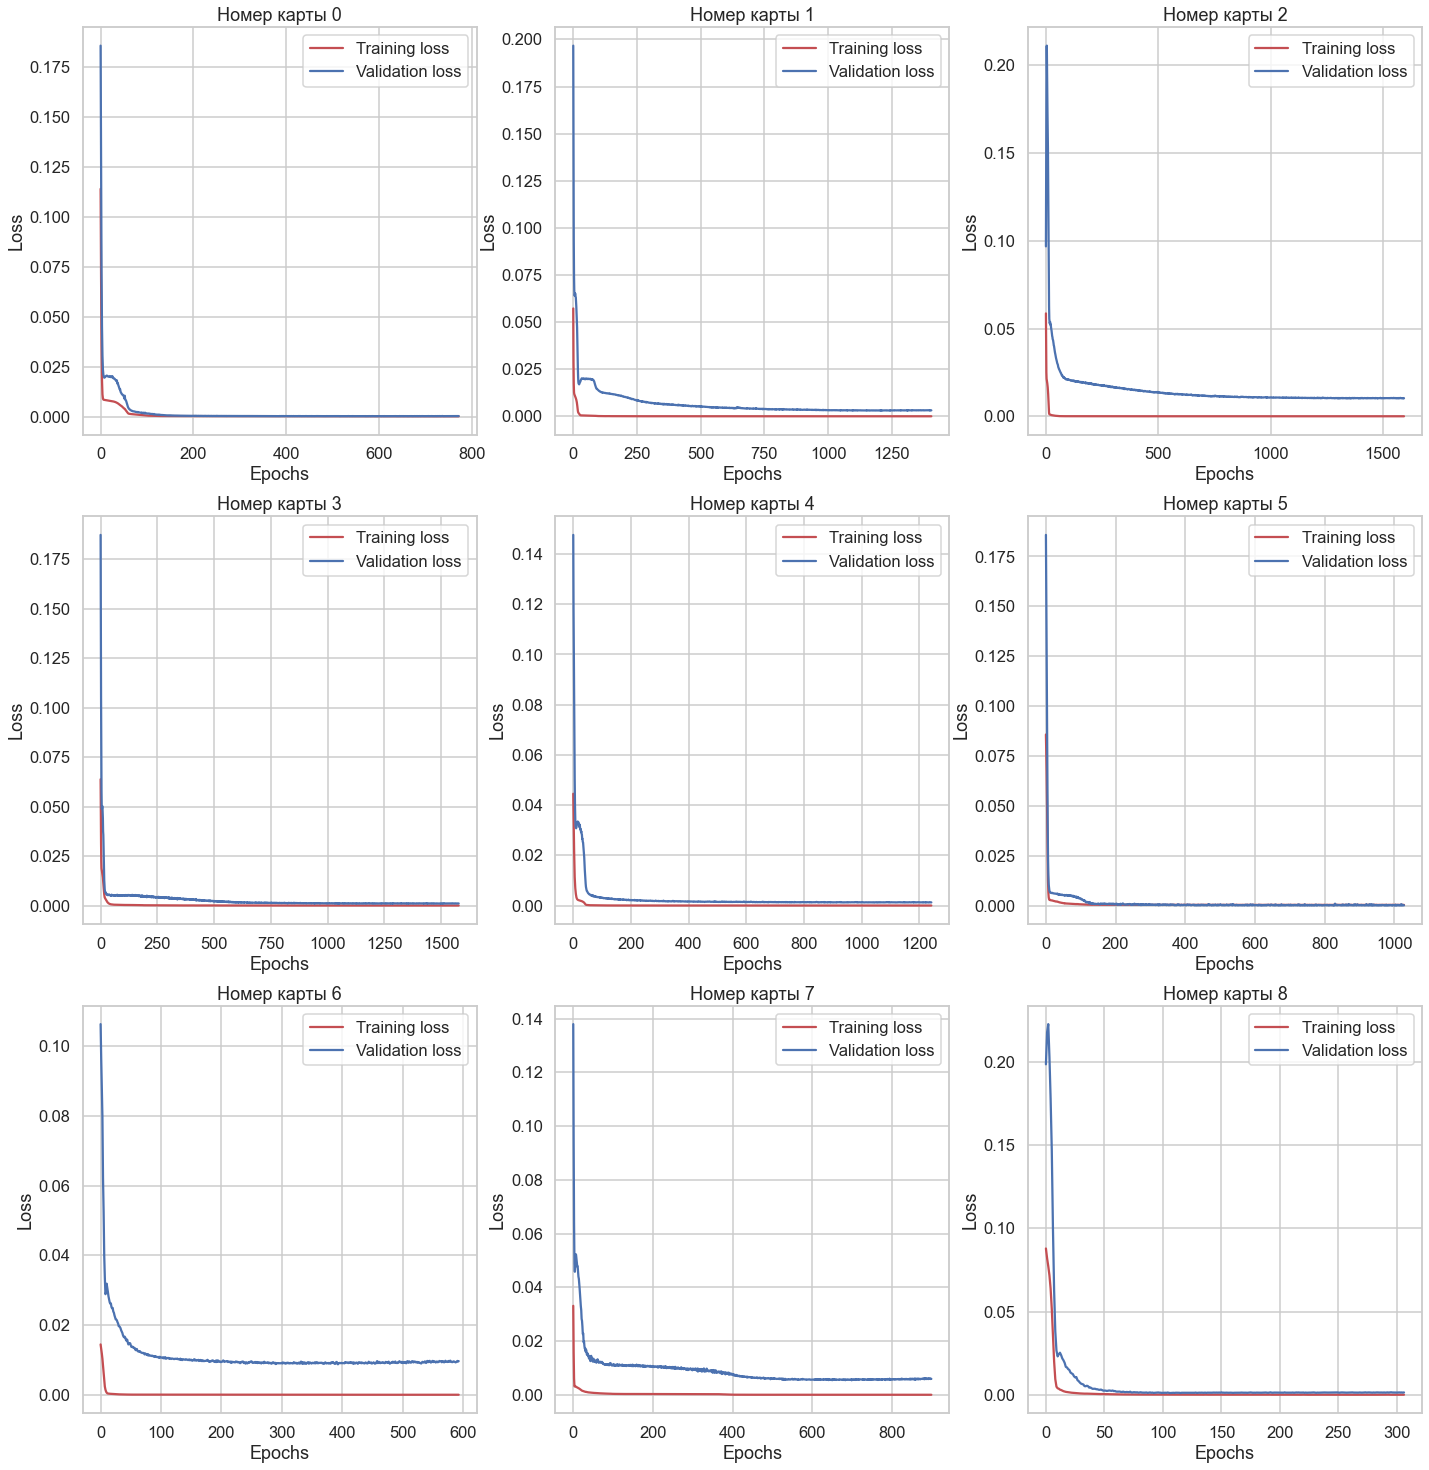

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for card_number in df_sv_card.keys():
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['loss'], 'r', label='Training loss')
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['val_loss'], 'b', label='Validation loss')
  plt.title(f'Номер карты {card_number}') 
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/loss_cards_syn_DS.png'):
  plt.savefig(f'{PNG_PATH}/loss_cards_syn_DS', dpi=100)
plt.show()

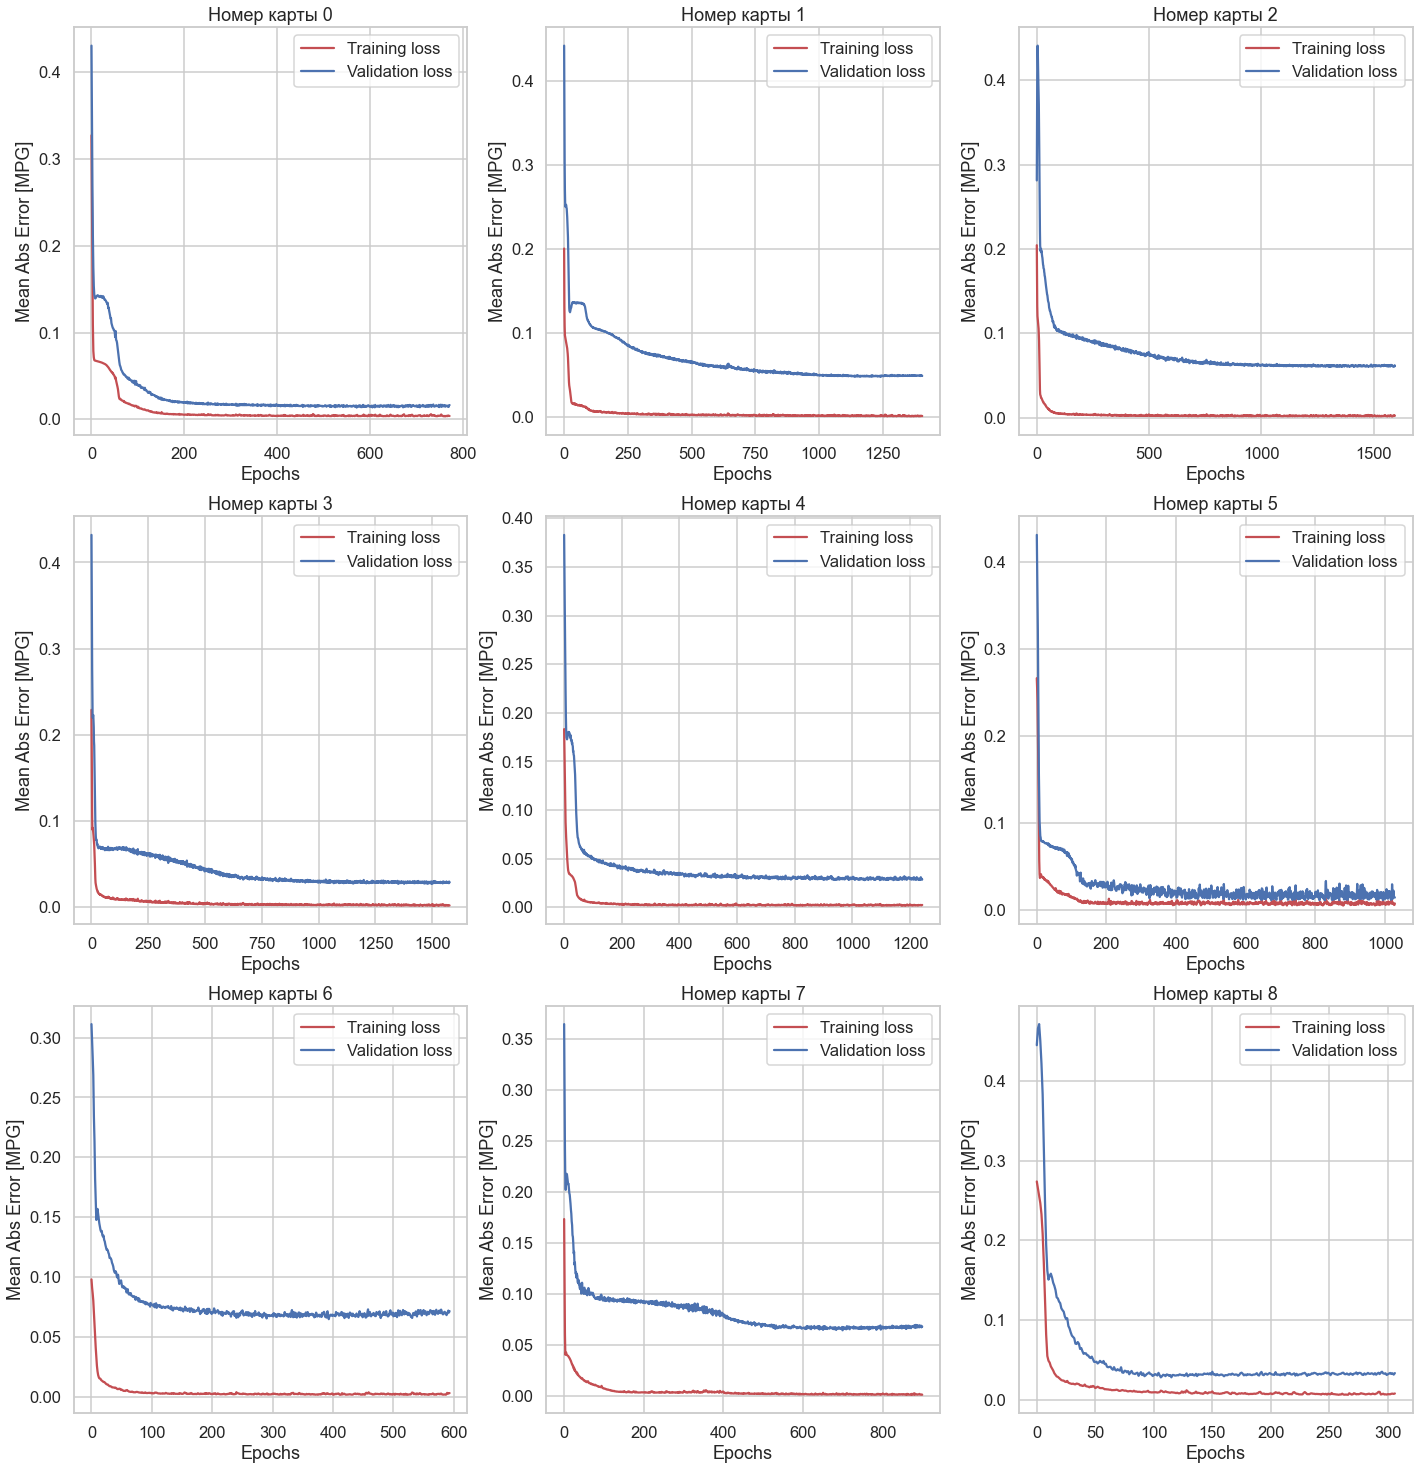

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for card_number in df_sv_card.keys():
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['mae'], 'r', label='Training loss')
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['val_mae'], 'b', label='Validation loss')
  plt.title(f'Номер карты {card_number}') 
  plt.xlabel('Epochs')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/mae_cards_syn_DS.png'):
  plt.savefig(f'{PNG_PATH}/mae_cards_syn_DS', dpi=100)
plt.show()

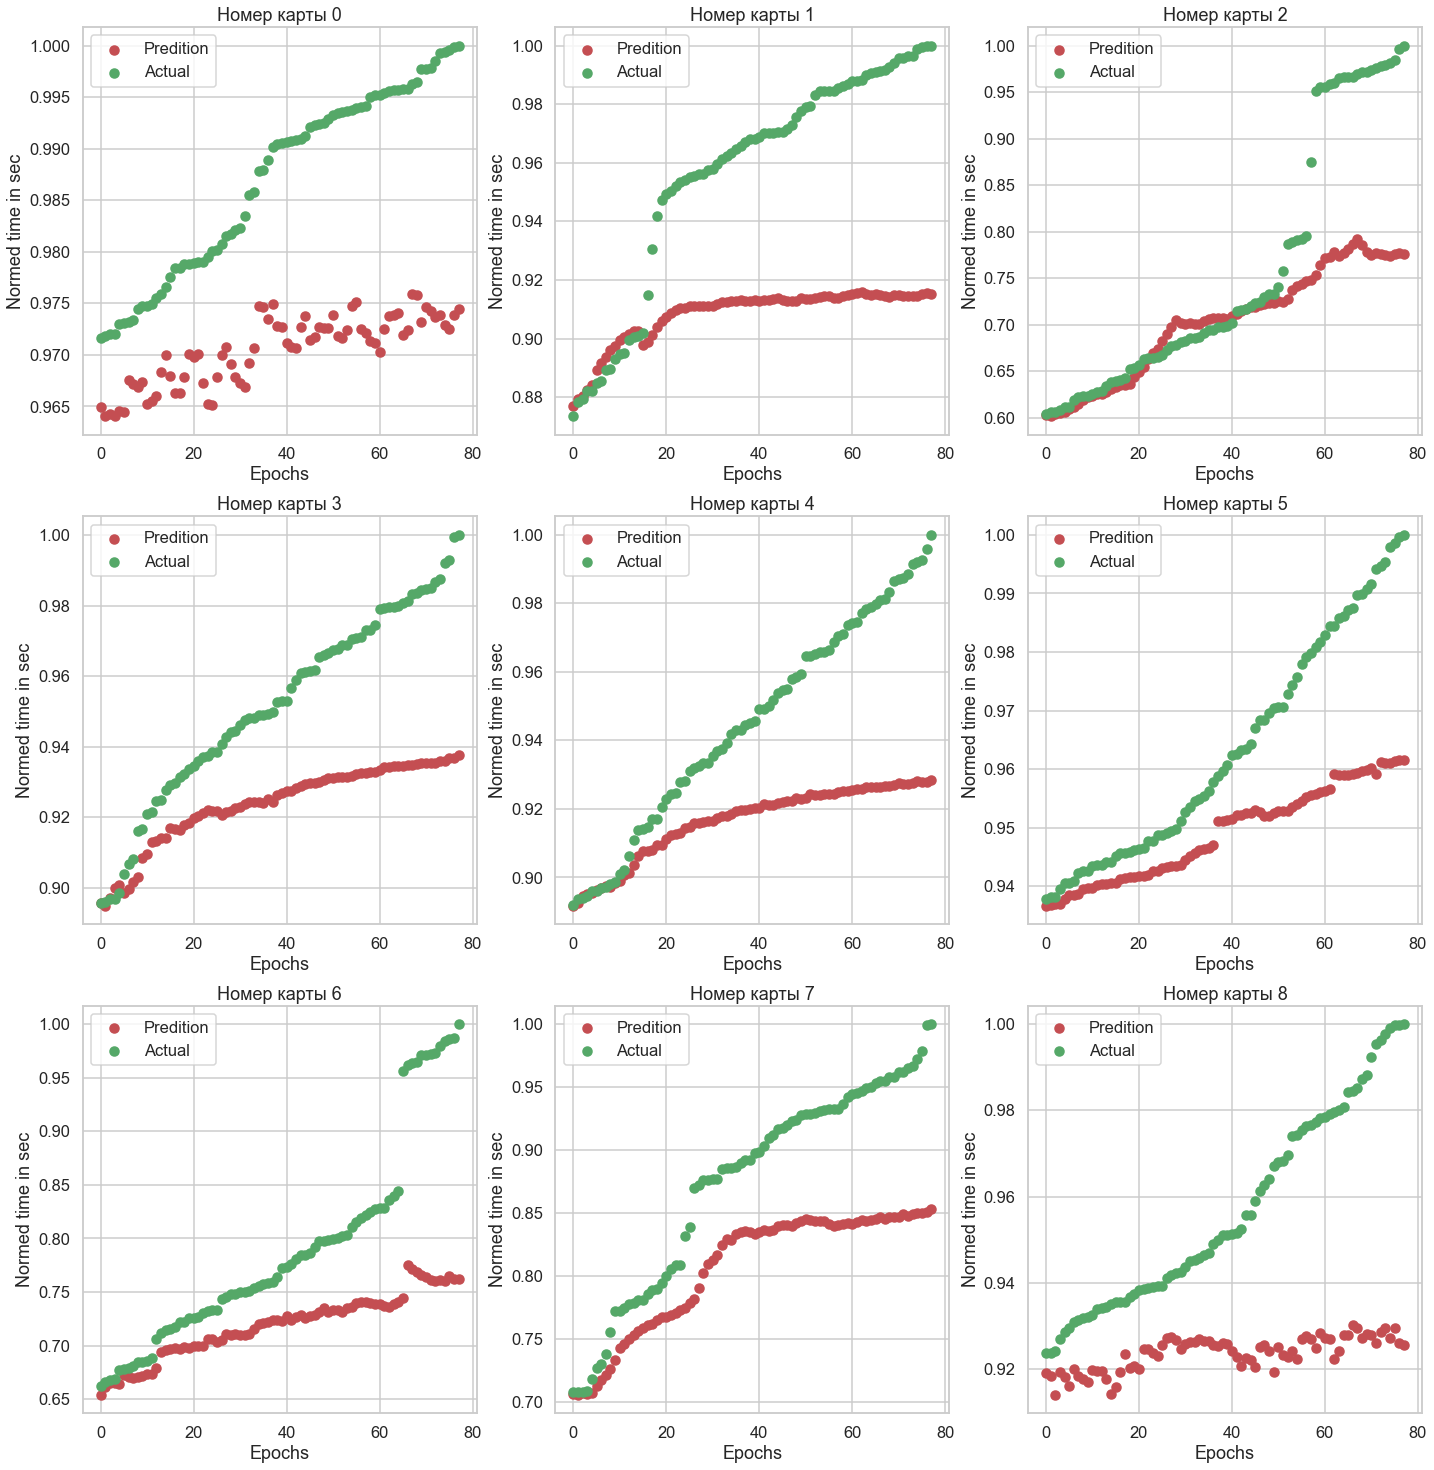

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for (result, i) in zip(model_results_save, df_sv_card.keys()):
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.scatter(range(y_test_d[i].shape[0]),np.array(result,dtype=float),c='r', label = 'Predition')
  plt.scatter(range(y_test_d[i].shape[0]),np.array(y_test_d[i],dtype=float),c='g', label = 'Actual')
  plt.title(f'Номер карты {i}') 
  plt.xlabel('Epochs')
  plt.ylabel('Normed time in sec')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/prediction_actual_cards_syn_DS.png'):
  plt.savefig(f'{PNG_PATH}/prediction_actual_cards_syn_DS', dpi=100)
plt.show()

### Получение accuracy

#### Денормализация

In [ ]:
data_sv_ns_t2 = copy.deepcopy(data_sv)

target_sv_ns_t2 = copy.deepcopy(target_sv)

x_train_d_t2 = copy.deepcopy(x_train_d)
x_test_d_t2 = copy.deepcopy(x_test_d)
y_train_d_t2 = copy.deepcopy(y_train_d)
y_test_d_t2 = copy.deepcopy(y_test_d)
model_results_t2 = copy.deepcopy(model_results_save)

In [ ]:
df_sv_card_normalized.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
### Денормализация
for index, i in enumerate(df_sv_card_normalized.keys()):
  
  for j in range(data_sv_ns_t2[i].shape[0]):
    data_sv_ns_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(data_sv_ns_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  target_sv_ns_t2[i][:,0] = max_min_scaler_denorm_for_the_column(target_sv_ns_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  for j in range(x_train_d_t2[i].shape[0]):
    x_train_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_train_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  for j in range(x_test_d_t2[i].shape[0]):
    x_test_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_test_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  y_train_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_train_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  y_test_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_test_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  model_results_t2[index][:,0] = max_min_scaler_denorm_for_the_column(model_results_t2[index][:,0], df_sv_card[i], 'DATE_TIME_SEC')


In [ ]:
print(x_train_d_t2[1].shape)
print(x_test_d_t2[1].shape)
print(y_train_d_t2[1].shape)
print(y_test_d_t2[1].shape)
print(data_sv[1].shape)
print(target_sv[1].shape)
print(model_results_t2[1].shape)

(312, 10, 14)
(78, 10, 14)
(312, 1)
(78, 1)
(390, 10, 14)
(390, 1)
(78, 1)


In [ ]:
for index, i in enumerate(df_sv_card_normalized.keys()):
  print(i, y_test_d_t2[i].shape, model_results_t2[index].shape, sep=' ')

0 (78, 1) (78, 1)
1 (78, 1) (78, 1)
2 (78, 1) (78, 1)
3 (78, 1) (78, 1)
4 (78, 1) (78, 1)
5 (78, 1) (78, 1)
6 (78, 1) (78, 1)
7 (78, 1) (78, 1)
8 (78, 1) (78, 1)


#### Получение бинарного признака и расчет accuracy для отдельных карт

In [ ]:
transaction_before_x_test = {}
actual_y_test = {}
prediction = {}
actual_class = {}
result_class = {}

In [ ]:
#Получаем время транзакций (последней в ряду, действительное время предсказываемой транзакции и предсказанное время)
for index, i in enumerate(df_sv_card_normalized.keys()):
  transaction_before_x_test[i] = x_test_d_t2[i][:,(x_test_d_t2[i].shape[1]-1),0] # последняя транзакция в ряду
  actual_y_test[i] = y_test_d_t2[i][:,0] #реальное время след транзакции по картам
  prediction[index] = model_results_t2[index][:,0] #предсказания по картам
  actual_class[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)
  result_class[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)

In [ ]:
actual_y_test.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
print(actual_y_test[1].shape,transaction_before_x_test[1].shape,prediction[2].shape, sep=' ')

(78,) (78,) (78,)


In [ ]:
#Строим массивы с бинарной классификацией транзакций которые произошли в следующие window_min минут после последней транзакции в ряду
window_min = 30
for index, j in enumerate(df_sv_card_normalized.keys()):
  for i in range(0, prediction[index].shape[0]):
    if (actual_y_test[j][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      actual_class[j][i] = 1
    else:
      actual_class[j][i] = 0
    if (prediction[index][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      result_class[j][i] = 1
    else:
      result_class[j][i] = 0
  actual_class[j] = actual_class[j].astype('int32')
  result_class[j] = result_class[j].astype('int32')

#### Получение среднего accuracy для кластеров

In [ ]:
accuracy_cards = {}

In [ ]:
actual_class[1][:10]

In [ ]:
result_class[1][:10]

In [ ]:
accuracy_score(actual_class[1]х, result_class[1])

In [ ]:
for i in df_sv_card_normalized.keys():
  accuracy_cards[i] = accuracy_score(actual_class[i][:3], result_class[i][:3])

In [ ]:
mean_acc = 0
for i in df_sv_card_normalized.keys():
  mean_acc = mean_acc + accuracy_cards[i]
mean_acc = mean_acc/len(accuracy_cards)
print(mean_acc)

In [ ]:
accuracy_cards

# Сравнение результатов

In [ ]:
list(df_clusters[df_clusters['labels_PCA']==0]['CARDID_NUM'])

In [ ]:
accuracy_cards[list(df_clusters[df_clusters['labels_PCA']==0]['CARDID_NUM'])]

In [ ]:
accuracy_cards_per_cluster = {}
for i in df_cl_dict_dict_norm.keys():
  accuracy_cards_per_cluster[i] = 0
for i in df_cl_dict_dict_norm.keys():
  for j in list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']):
    accuracy_cards_per_cluster[i] = accuracy_cards_per_cluster[i] + accuracy_cards[j]
  accuracy_cards_per_cluster[i] = accuracy_cards_per_cluster[i]/len(list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']))

In [ ]:
accuracy_cards_per_cluster

In [ ]:
accuracy_clusters

### График

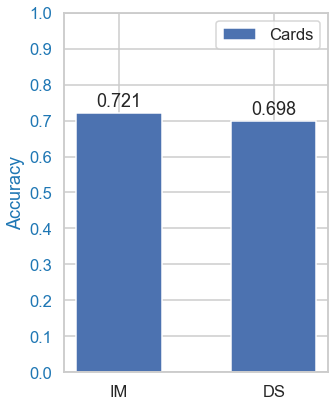

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['IM', 'DS']
kards = [0.721, 0.698]
cluster = [0.396, 0.656]


x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

fig, ax1 = plt.subplots(figsize=(5,6))
rects1 = ax1.bar(x, kards, width, label='Cards')

# Add some text for labels, title and custom x-axis tick labels, etc.
color = 'tab:blue'
ax1.set_ylabel('Accuracy', color=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((0.0,1.0))
ax1.locator_params(nbins=10, axis='y')
ax1.legend()

ax1.bar_label(rects1, padding=3)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


#fig.set_figwidth(12)    #  ширина Figure
#fig.set_figheight(6)    #  высота Figure

if not os.path.isfile(f'{PNG_PATH}/final_result_syn_LSTM.png'):
  plt.savefig(f'{PNG_PATH}/final_result_syn_LSTM', dpi=300)  
plt.show()